In [1]:
import sys
import os
project_dir = os.path.abspath("/bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/temporal_ppe_emulation/scripts")
#---------- Define paths for the specific subfolders
data_scripts_path = os.path.join(project_dir, "data_processing")
model_scripts_path = os.path.join(project_dir, "model")
#---------- Append the subfolder paths to sys.path
sys.path.append(data_scripts_path)
sys.path.append(model_scripts_path)

In [2]:
from packages import*

2025-04-09 10:30:17.155928: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-09 10:30:17.219976: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-09 10:30:19.309457: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from annual_data_loader import x_input, y_input
from global_mean import  global_mean
from temporal_ednn import ednn_reg_model

## Load Data

In [4]:
#---------- Compute CLM PPE season
clm_ppe_path ="/bsuhome/ksilwimba/scratch/NCAR/Data/LAI/TLAI"
clm_ppe_data_tr = y_input(clm_ppe_path, start_year=1901, end_year=2000)
clm_ppe_data_va = y_input(clm_ppe_path, start_year=2000, end_year=2014)

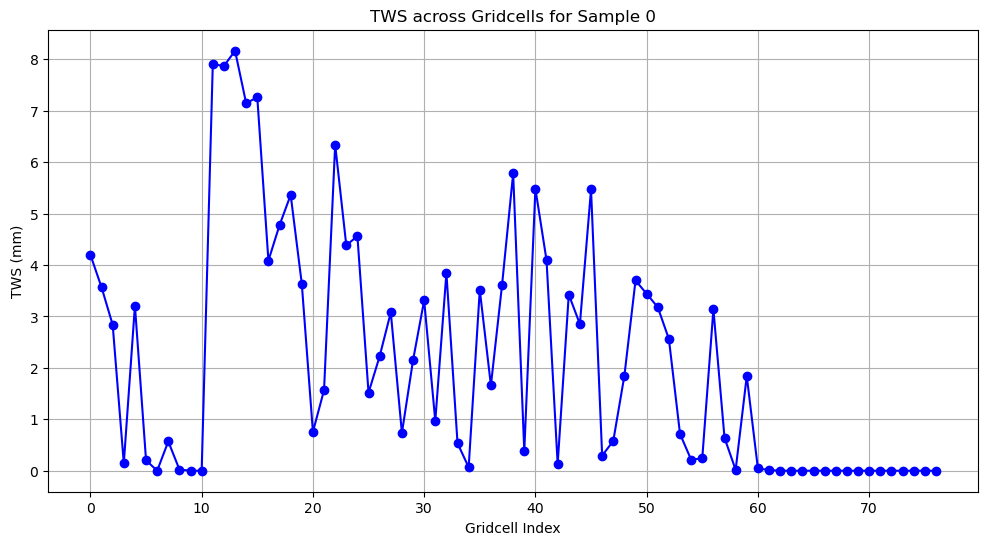

In [5]:
sample_index = 0
tlai_data = clm_ppe_data_tr['TLAI'].isel(sample=sample_index)

#------------ Plot TLAI values across grid cells
plt.figure(figsize=(12, 6))
plt.plot(tlai_data.gridcell, tlai_data, marker='o', linestyle='-', color='b')
plt.xlabel("Gridcell Index")
plt.ylabel("TWS (mm)")
plt.title(f"TWS across Gridcells for Sample {sample_index}")
plt.grid(True)
plt.show()

In [6]:
param_file_path = "/bsuhome/ksilwimba/scratch/NCAR/Data/helpers/lhc220926.txt"

#---------- Create x-train input
x_tr, x_tr_no_cyclic = x_input(clm_ppe_data_tr, param_file_path)

#---------- Create x-train input
x_va, x_va_no_cyclic = x_input(clm_ppe_data_va, param_file_path)

## Compute Global Mean 

In [7]:
#----------- Area weight
land_area = xr.open_dataset('/bsuhome/ksilwimba/scratch/NCAR/Data/helpers/sparsegrid_landarea.nc').landarea

#----------- Train Y global mean 
tr_gmean = global_mean(clm_ppe_data_tr, land_area)
tr_gmean = tr_gmean.TLAI.values.reshape(-1,1)
#----------- Validation Y global mean 
va_gmean = global_mean(clm_ppe_data_va, land_area)
va_gmean = va_gmean.TLAI.values.reshape(-1,1)

## Scale Data

#### Scaling

In [8]:
#----------- Scaled Y train global mean 
scaler_y = StandardScaler()
tr_gmean_scaled = scaler_y.fit_transform(tr_gmean)

#----------- Scaled Y validation global mean 
va_gmean_scaled = scaler_y.transform(va_gmean)

In [9]:
tr_gmean_scaled

array([[ 0.01543477],
       [-0.15877779],
       [-0.25398613],
       ...,
       [ 0.28942551],
       [ 0.08234968],
       [ 0.09207506]])

In [10]:
#----------- Scaled x train and validation
scaler_x = StandardScaler()
x_tr_scaled = scaler_x.fit_transform(x_tr)

x_va_scaled = scaler_x.transform(x_va)

## EDNN Model 

## Train EDNN Model 

In [11]:
batch_size=1200
model_folder = "/bsuhome/ksilwimba/scratch/clm5-lai-ppe-ednn/temporal_ppe_emulation/saved_model"
#---------- Train  Annual Model
model_path = model_folder+"/ednn_reg_model.keras"
p_with_unc, p_without_unc, model, history = ednn_reg_model(x_tr_scaled,\
                                                           tr_gmean,batch_size, model_path, hidden_layers=6,
                                                           epochs=15, loss_weight=0.001)

Epoch 1/15
500/500 - 3s - 6ms/step - loss: -1.7349e+00 - mse: 15.1405
Epoch 2/15
500/500 - 2s - 3ms/step - loss: -2.4321e+00 - mse: 24.0940
Epoch 3/15
500/500 - 2s - 3ms/step - loss: -2.5603e+00 - mse: 27.9528
Epoch 4/15
500/500 - 2s - 3ms/step - loss: -2.6466e+00 - mse: 30.4880
Epoch 5/15
500/500 - 2s - 3ms/step - loss: -2.6788e+00 - mse: 32.3401
Epoch 6/15
500/500 - 2s - 3ms/step - loss: -2.7137e+00 - mse: 34.1578
Epoch 7/15
500/500 - 2s - 3ms/step - loss: -2.7298e+00 - mse: 35.6215
Epoch 8/15
500/500 - 2s - 3ms/step - loss: -2.7541e+00 - mse: 36.9457
Epoch 9/15
500/500 - 2s - 3ms/step - loss: -2.7763e+00 - mse: 38.2531
Epoch 10/15
500/500 - 1s - 3ms/step - loss: -2.7809e+00 - mse: 39.2489
Epoch 11/15
500/500 - 1s - 3ms/step - loss: -2.8045e+00 - mse: 40.3031
Epoch 12/15
500/500 - 2s - 3ms/step - loss: -2.8188e+00 - mse: 41.2788
Epoch 13/15
500/500 - 1s - 3ms/step - loss: -2.8352e+00 - mse: 42.3356
Epoch 14/15
500/500 - 1s - 3ms/step - loss: -2.8387e+00 - mse: 43.0540
Epoch 15/15
500

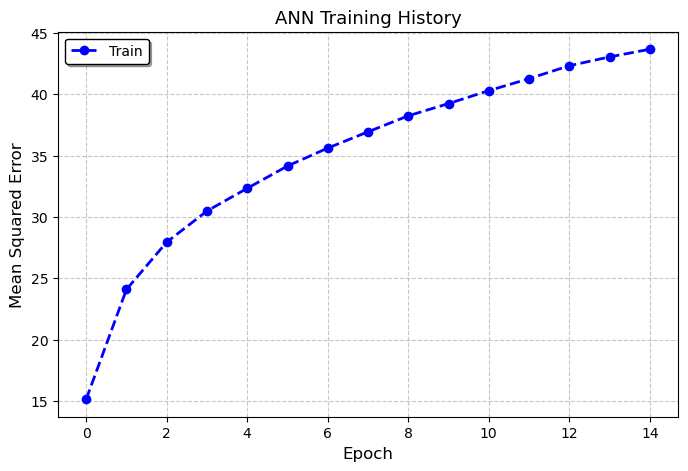

In [12]:
plt.figure(figsize=(8, 5))
plt.plot(history.epoch, history.history['mse'], label='Train', marker='o', linestyle='--', linewidth=2, color='blue')
plt.legend(shadow = True, edgecolor='black')
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylabel('Mean Squared Error', fontsize = 12)
plt.xlabel('Epoch', fontsize=12)
plt.title('ANN Training History', fontsize=13)
plt.savefig("./Figures/TSgrid_mse_anom.pdf", bbox_inches='tight')
plt.show()

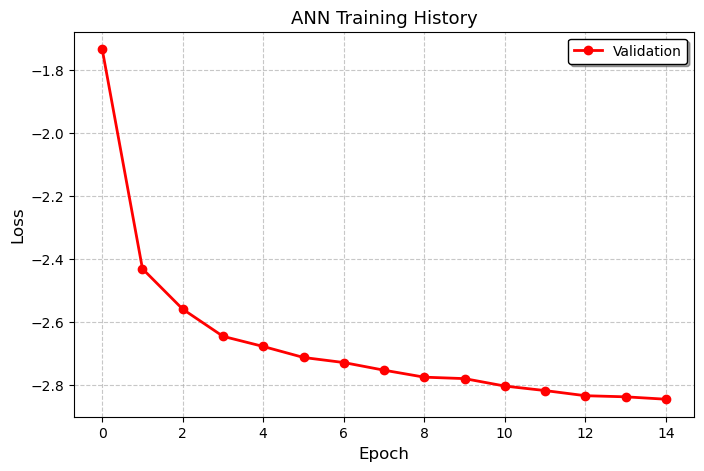

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(history.epoch, history.history['loss'], label='Validation', marker='o', linestyle='-', linewidth=2, color='red')
plt.legend(shadow = True, edgecolor='black')
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylabel('Loss', fontsize = 12)
plt.xlabel('Epoch', fontsize=12)
plt.title('ANN Training History', fontsize=13)
plt.savefig("./Figures/TSgrid_mse_anom.pdf", bbox_inches='tight')
plt.show()

In [14]:
########### cyclical encoded prediction 
#------------- predictions
pred = model.predict(x_va_scaled, return_uncertainties=True)
# pred = scaler_y.inverse_transform(pred[:, 0].reshape(1, -1))

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [15]:
pred 

array([[5.3183365e-01, 1.6135293e-04, 1.9047915e-05],
       [4.9643213e-01, 1.5135575e-04, 1.7741506e-05],
       [4.6530688e-01, 1.5374475e-04, 1.8085830e-05],
       ...,
       [4.9857211e-01, 1.3702098e-04, 1.5559035e-05],
       [4.6991032e-01, 1.2019590e-04, 1.3469940e-05],
       [4.4865125e-01, 9.6307631e-05, 1.0535029e-05]], dtype=float32)

In [16]:
# =============================================================================
# Create PPE Prediction DataFrame and Convert Time Format
# =============================================================================

# ---------- Write PPE predictions to a DataFrame
ppe_pred = pd.DataFrame({
    "member": clm_ppe_data_va.member,
    "time": clm_ppe_data_va.time,
    "ednn_mu": pred[:, 0].squeeze(),
    "clm_model": va_gmean.squeeze(),
    "ednn_alea": pred[:, 1].squeeze(),
    "ednn_epis": pred[:, 2].squeeze()
})

# ---------- Define a helper function to convert cftime objects to numpy.datetime64
def convert_cftime_to_datetime64(cf_time):
    return np.datetime64(f"{cf_time.year}-{cf_time.month:02d}-{cf_time.day:02d}")

# ---------- Apply the conversion function to the 'time' column and add a "month" column
ppe_pred['time'] = ppe_pred['time'].apply(convert_cftime_to_datetime64)
ppe_pred["month"] = ppe_pred.time.dt.month


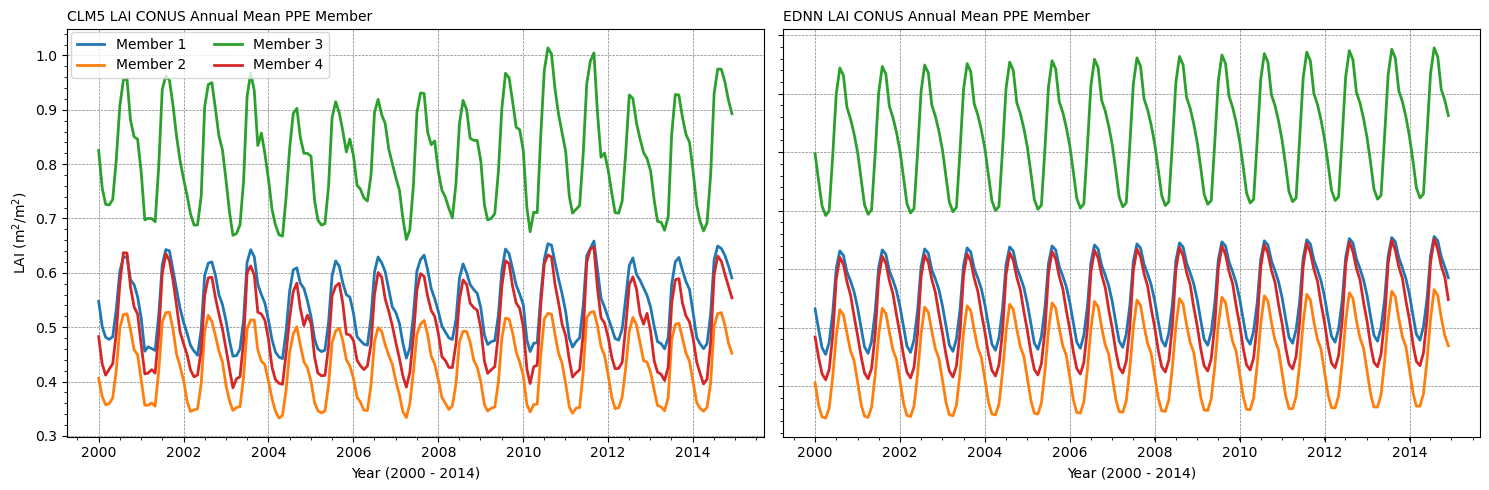

In [17]:
# =============================================================================
# LAI CONUS Annual Mean PPE Member Comparison
# =============================================================================

# ---------- Create a figure with 1 row and 2 columns of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# ---------- Initialize lists to store legend handles and labels for the left subplot
handles, labels = [], []

# ---------- Plot the CLM5 model predictions for each member in the left subplot
for i in range(1, 5):
    # Filter the DataFrame for the current member
    member_data = ppe_pred[ppe_pred['member'] == i]
    # Plot time vs CLM model values
    line, = axes[0].plot(member_data['time'].values, member_data['clm_model'].values,
                           label=f'Member {i}', linewidth=2)
    handles.append(line)
    labels.append(f'Member {i}')

# ---------- Customize the left subplot (CLM5 predictions)
axes[0].set_title('CLM5 LAI CONUS Annual Mean PPE Member', fontsize=10, fontweight='regular', loc="left")
axes[0].set_ylabel('LAI (m$^2$/m$^2$)', fontsize=10)
axes[0].set_xlabel('Year (2000 - 2014)', fontsize=10)
axes[0].minorticks_on()
axes[0].grid(linestyle='--', linewidth=0.5, color='grey')

# ---------- Plot the EDNN predictions for each member in the right subplot
for i in range(1, 5):
    # Filter the DataFrame for the current member
    member_data = ppe_pred[ppe_pred['member'] == i]
    # Plot time vs EDNN prediction mean values
    axes[1].plot(member_data['time'].values, member_data['ednn_mu'].values,
                 linestyle="-", linewidth=2)

# ---------- Customize the right subplot (EDNN predictions)
axes[1].set_title('EDNN LAI CONUS Annual Mean PPE Member', fontsize=10, fontweight='regular', loc="left")
axes[1].set_xlabel('Year (2000 - 2014)', fontsize=10)
axes[1].yaxis.set_tick_params(labelleft=False)
axes[1].minorticks_on()
axes[1].grid(linestyle='--', linewidth=0.5, color='grey')

# ---------- Add legend to the figure (for left subplot)
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.227, 0.88), ncol=2)

# ---------- Adjust layout and save the figure as a PDF
plt.tight_layout()
plt.savefig("./Figures/LAI_conus.pdf", bbox_inches='tight')
plt.show()


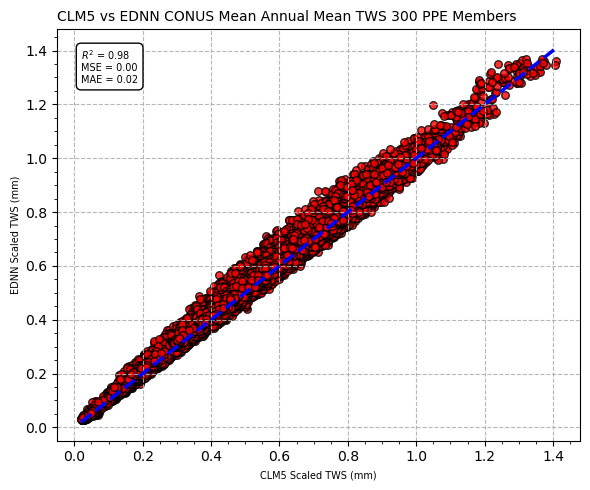

In [18]:
# =============================================================================
# Scatter Plot with Regression Metrics for Filtered PPE Data
# =============================================================================

# ---------- Filter the DataFrame by 'member' column (select members 1 through 299)
df = ppe_pred[ppe_pred['member'].isin(range(1, 500))]

# ---------- Create the figure
plt.figure(figsize=(6, 5))

# ---------- Calculate regression metrics (R², MSE, MAE)
r2_value = r2_score(df["clm_model"], df["ednn_mu"])
mse_value = mean_squared_error(df["clm_model"], df["ednn_mu"])
mae_value = mean_absolute_error(df["clm_model"], df["ednn_mu"])

# ---------- Determine the min and max values for the CLM model predictions (for the 1:1 line)
season_min = np.min(df["clm_model"])
season_max = np.max(df["clm_model"])

# ---------- Create a scatter plot for data points (using coral color)
plt.scatter(df["clm_model"], df["ednn_mu"], label='Data Points', color="r", alpha=0.8, edgecolor='black', s=30)

# ---------- Plot the 1:1 line (dashed blue line)
plt.plot([season_min, season_max], [season_min, season_max], linewidth=2.5, linestyle='--', c='b', label='1:1 Line')

# ---------- Set axis labels
plt.xlabel('CLM5 Scaled TWS (mm)', fontsize=7, color='k')
plt.ylabel('EDNN Scaled TWS (mm)', fontsize=7, color='k')

# ---------- Set the plot title
plt.title('CLM5 vs EDNN CONUS Mean Annual Mean TWS 300 PPE Members', fontsize=10, loc="left")

# ---------- Configure gridlines, minor ticks, and tick parameters
plt.grid(True, linestyle='--', alpha=0.9)
plt.minorticks_on()
plt.tick_params(axis='x', colors='k')
plt.tick_params(axis='y', colors='k')

# ---------- Annotate the regression metrics with a bounding box for clarity
plt.text(season_min, season_max, 
         f'$R^2$ = {r2_value:.2f}\nMSE = {mse_value:.2f}\nMAE = {mae_value:.2f}', 
         fontsize=7, color='black', verticalalignment='top',
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# ---------- Adjust layout, save the figure as a PNG, and display the plot
plt.tight_layout()
plt.savefig("./Figures/scatter_plot_with_metrics.png", bbox_inches='tight')
plt.show()


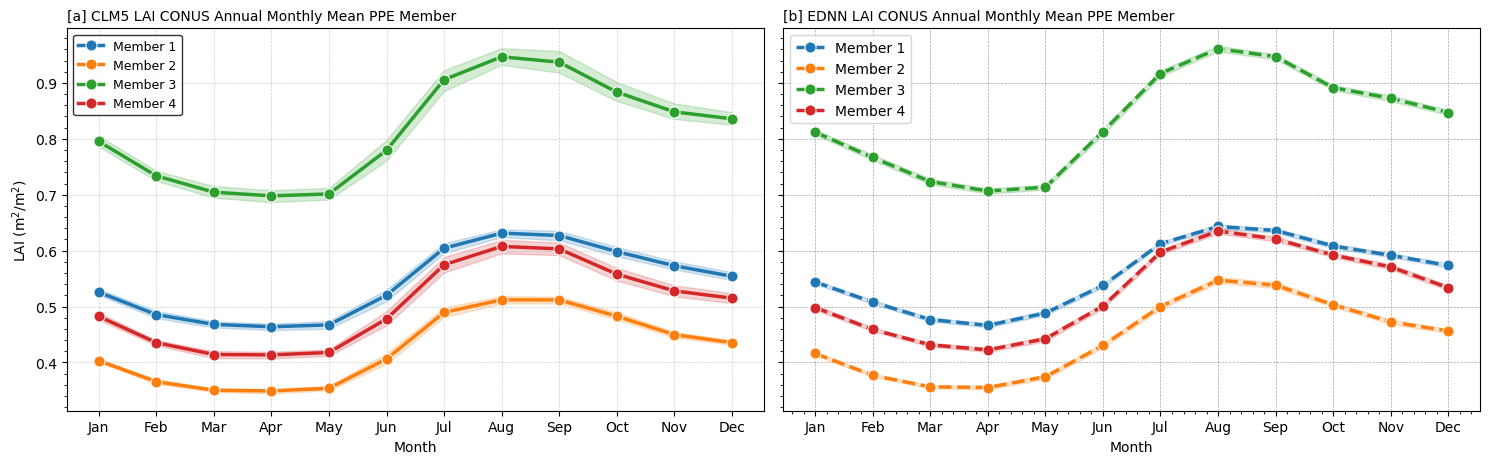

In [19]:
# =============================================================================
## Monthly LAI Comparison for CONUS PPE Members
# =============================================================================

# ---------- Set global PDF settings for publication-quality fonts
plt.rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded in the PDF
plt.rcParams['ps.fonttype'] = 42

# ---------- Define a color palette for ensemble members using seaborn's "tab10"
colors = sns.color_palette("tab10", 5)  # 4 distinct colors for members 1-4

# ---------- Create subplots with one row and two columns (shared y-axis)
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# ---------- Define month labels for the x-axis
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# ---------- Plot CLM5 LAI in the first subplot
for i in range(1, 5):
    # ---------- Filter data for the current ensemble member
    member_data = ppe_pred[ppe_pred['member'] == i]
    sns.lineplot(
        ax=axes[0], 
        x=member_data['month'], 
        y=member_data['clm_model'], 
        label=f'Member {i}', 
        color=colors[i-1], 
        marker='o', 
        linestyle='-', 
        linewidth=2.5,
        markersize=8
    )

# ---------- Customize the left subplot (CLM5 predictions)
axes[0].set_title('[a] CLM5 LAI CONUS Annual Monthly Mean PPE Member', fontsize=10, loc="left")
axes[0].set_xlabel('Month', fontsize=10)
axes[0].set_ylabel('LAI (m$^2$/m$^2$)', fontsize=10)
axes[0].set_xticks(range(1, 13))
axes[0].set_xticklabels(month_labels, fontsize=10)
axes[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
axes[0].legend(loc='upper left', fontsize=9, frameon=True, edgecolor='black')

# ---------- Plot EDNN LAI in the second subplot
for i in range(1, 5):
    # ---------- Filter data for the current ensemble member
    member_data = ppe_pred[ppe_pred['member'] == i]
    sns.lineplot(
        ax=axes[1], 
        x=member_data['month'], 
        y=member_data['ednn_mu'], 
        label=f'Member {i}', 
        color=colors[i-1], 
        marker='o', 
        linestyle='--', 
        linewidth=2.5,
        markersize=8
    )

# ---------- Customize the right subplot (EDNN predictions)
axes[1].set_title('[b] EDNN LAI CONUS Annual Monthly Mean PPE Member', fontsize=10, loc="left")
axes[1].set_xlabel('Month', fontsize=10)
axes[1].set_xticks(range(1, 13))
axes[1].set_xticklabels(month_labels, fontsize=10)
axes[1].minorticks_on()
axes[1].grid(linestyle='--', linewidth=0.5, color='grey', alpha=0.7)

# ---------- Adjust layout and save the figure with high resolution
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("./Figures/monthly.pdf", bbox_inches='tight', dpi=300)
plt.show()


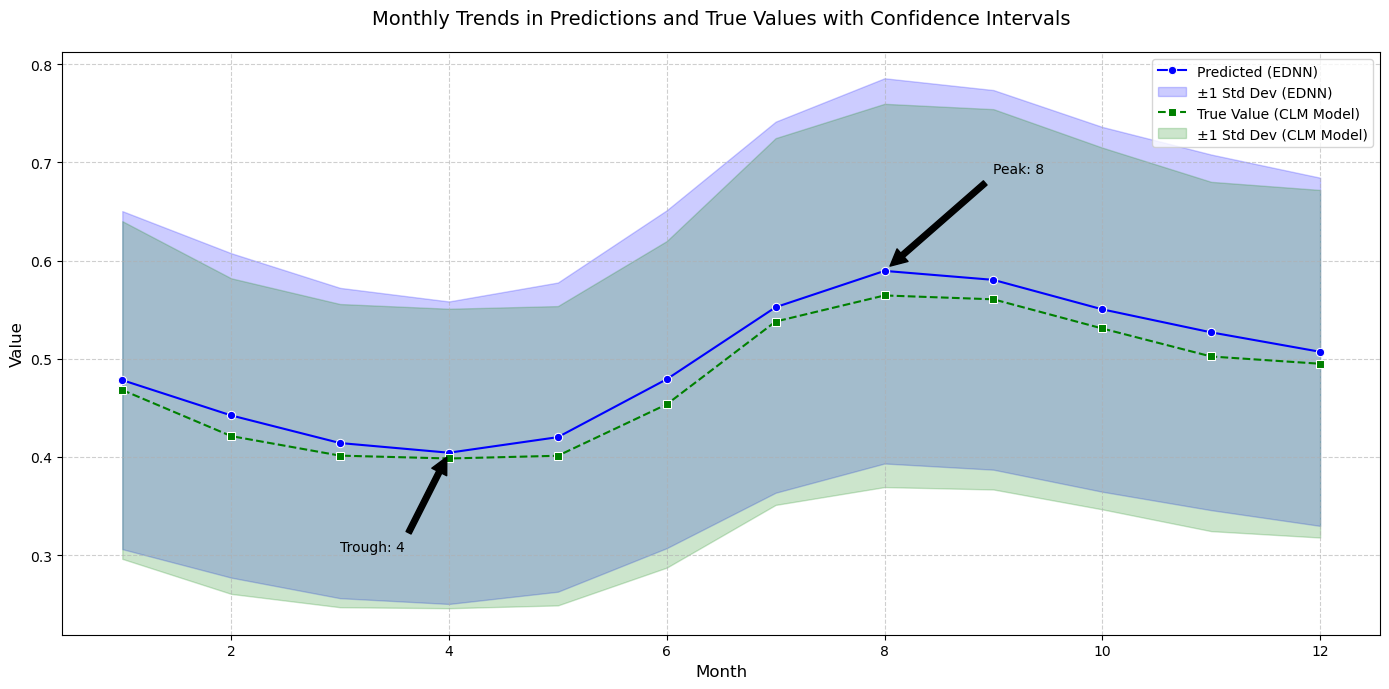

In [20]:
# =============================================================================
# Monthly Trends in PPE Predictions with Confidence Intervals
# =============================================================================

# ---------- Group by month and calculate mean values and standard deviations
monthly_agg = ppe_pred.groupby('month').agg({
    'ednn_mu': ['mean', 'std'],
    'clm_model': ['mean', 'std']
}).reset_index()

# ---------- Flatten the multi-level column names
monthly_agg.columns = ['month', 'ednn_mu_mean', 'ednn_mu_std', 'clm_model_mean', 'clm_model_std']

# ---------- Create a figure for the monthly trends with confidence intervals
plt.figure(figsize=(14, 7))

# ---------- Plot predicted values (EDNN) with confidence intervals
sns.lineplot(x=monthly_agg['month'], y=monthly_agg['ednn_mu_mean'], 
             label='Predicted (EDNN)', color='blue', marker='o', linestyle='-')
plt.fill_between(monthly_agg['month'], 
                 monthly_agg['ednn_mu_mean'] - monthly_agg['ednn_mu_std'], 
                 monthly_agg['ednn_mu_mean'] + monthly_agg['ednn_mu_std'], 
                 color='blue', alpha=0.2, label='±1 Std Dev (EDNN)')

# ---------- Plot true values (CLM Model) with confidence intervals
sns.lineplot(x=monthly_agg['month'], y=monthly_agg['clm_model_mean'], 
             label='True Value (CLM Model)', color='green', marker='s', linestyle='--')
plt.fill_between(monthly_agg['month'], 
                 monthly_agg['clm_model_mean'] - monthly_agg['clm_model_std'], 
                 monthly_agg['clm_model_mean'] + monthly_agg['clm_model_std'], 
                 color='green', alpha=0.2, label='±1 Std Dev (CLM Model)')

# ---------- Add gridlines for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# ---------- Add annotations for key months (peak and trough for EDNN predictions)
peak_month = monthly_agg.loc[monthly_agg['ednn_mu_mean'].idxmax(), 'month']
trough_month = monthly_agg.loc[monthly_agg['ednn_mu_mean'].idxmin(), 'month']
plt.annotate(f'Peak: {peak_month}', 
             xy=(peak_month, monthly_agg.loc[monthly_agg['month'] == peak_month, 'ednn_mu_mean'].values[0]), 
             xytext=(peak_month + 1, monthly_agg['ednn_mu_mean'].max() + 0.1), 
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'Trough: {trough_month}', 
             xy=(trough_month, monthly_agg.loc[monthly_agg['month'] == trough_month, 'ednn_mu_mean'].values[0]), 
             xytext=(trough_month - 1, monthly_agg['ednn_mu_mean'].min() - 0.1), 
             arrowprops=dict(facecolor='black', shrink=0.05))

# ---------- Customize labels and title
plt.xlabel('Month', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.title('Monthly Trends in Predictions and True Values with Confidence Intervals', fontsize=14, pad=20)

# ---------- Add legend and adjust layout
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()

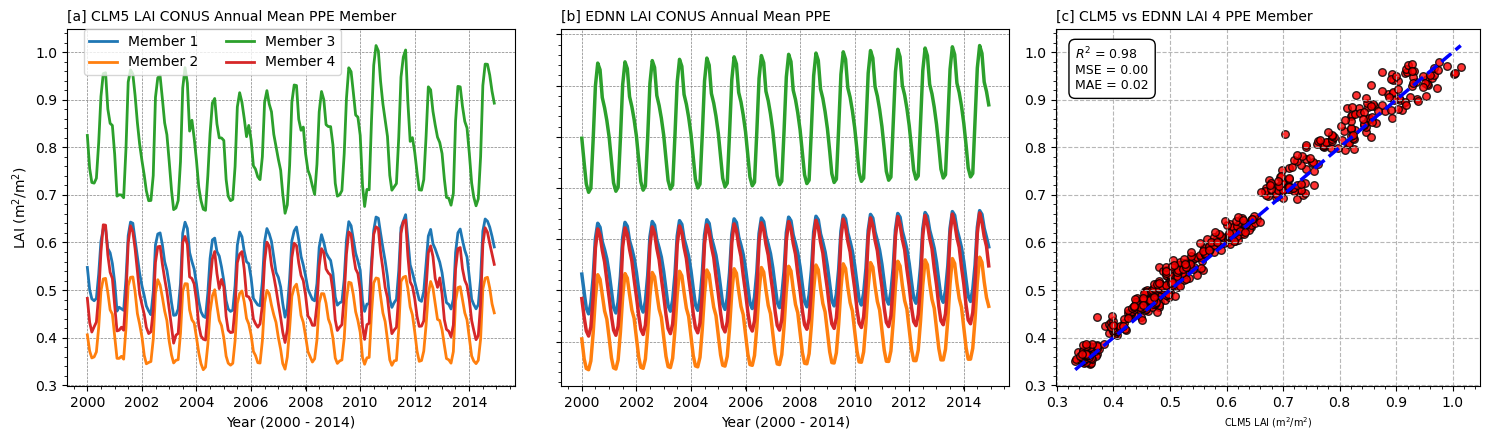

In [21]:
# =============================================================================
# Combined Plot for CLM5 and EDNN LAI CONUS PPE Members
# =============================================================================

# ---------- Create the figure and GridSpec layout with 3 columns
fig = plt.figure(figsize=(15, 4.5))
gs = GridSpec(1, 3, figure=fig, width_ratios=[1.9, 1.9, 1.8])

# ---------- Subplot 1: CLM5 LAI CONUS Annual Mean PPE Member
ax1 = fig.add_subplot(gs[0])
handles, labels = [], []

# ---------- Plot CLM5 predictions (members 1 to 4) with line plots in subplot 1
for i in range(1, 5):
    member_data = ppe_pred[ppe_pred['member'] == i]
    line, = ax1.plot(
        member_data['time'].values,
        member_data['clm_model'].values,
        label=f'Member {i}', linewidth=2
    )
    handles.append(line)
    labels.append(f'Member {i}')
ax1.set_title('[a] CLM5 LAI CONUS Annual Mean PPE Member', fontsize=10, loc="left")
ax1.set_ylabel('LAI (m$^2$/m$^2$)', fontsize=10)
ax1.set_xlabel('Year (2000 - 2014)', fontsize=10)
ax1.minorticks_on()
ax1.grid(linestyle='--', linewidth=0.5, color='grey')

# ---------- Subplot 2: EDNN LAI CONUS Annual Mean PPE
ax2 = fig.add_subplot(gs[1])
# ---------- Plot EDNN predictions (members 1 to 4) with line plots in subplot 2
for i in range(1, 5):
    member_data = ppe_pred[ppe_pred['member'] == i]
    ax2.plot(
        member_data['time'].values,
        member_data['ednn_mu'].values,
        linestyle="-", linewidth=2.5
    )
ax2.set_title('[b] EDNN LAI CONUS Annual Mean PPE', fontsize=10, loc="left")
ax2.set_xlabel('Year (2000 - 2014)', fontsize=10)
ax2.yaxis.set_tick_params(labelleft=False)
ax2.minorticks_on()
ax2.grid(linestyle='--', linewidth=0.5, color='grey')

# ---------- Subplot 3: Scatter Plot with Regression Metrics
ax3 = fig.add_subplot(gs[2])
# ---------- Filter data for members 1 to 3 for scatter analysis
df = ppe_pred[ppe_pred['member'].isin(range(1, 4))]
r2_value = r2_score(df["clm_model"], df["ednn_mu"])
mse_value = mean_squared_error(df["clm_model"], df["ednn_mu"])
mae_value = mean_absolute_error(df["clm_model"], df["ednn_mu"])
season_min = np.min(df["clm_model"])
season_max = np.max(df["clm_model"])

# ---------- Create scatter plot and 1:1 line
ax3.scatter(
    df["clm_model"], df["ednn_mu"], label='Data Points',
    color="r", alpha=0.8, edgecolor='black', s=30
)
ax3.plot(
    [season_min, season_max], [season_min, season_max],
    linewidth=2.5, linestyle='--', c='b', label='1:1 Line'
)
ax3.set_xlabel('CLM5 LAI (m$^2$/m$^2$)', fontsize=7)
ax3.set_title('[c] CLM5 vs EDNN LAI 4 PPE Member', fontsize=10, loc="left")
ax3.grid(True, linestyle='--', alpha=0.9)
ax3.minorticks_on()

# ---------- Annotate regression metrics on the scatter plot with a bounding box
ax3.text(
    season_min, season_max,
    f'$R^2$ = {r2_value:.2f}\nMSE = {mse_value:.2f}\nMAE = {mae_value:.2f}', 
    fontsize=9, color='black', verticalalignment='top',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)

# ---------- Add a legend for subplots 1 and 2 (using the handles/labels from subplot 1)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.145, 0.94), ncol=2)

# ---------- Adjust layout and save the figure as a PDF
plt.tight_layout()
plt.savefig("./Figures/combined_plot.pdf", bbox_inches='tight')
plt.show()

In [22]:
############# Write to df
ppe_pred_ = pd.DataFrame({"ppe_member":clm_ppe_data_va.member, "time":clm_ppe_data_va.time,\
                         "ednn_pred":pred[:,0].squeeze(),"true_value":va_gmean_scaled.squeeze(), "ednn_alea":pred[:,1].squeeze(), "ednn_epis":pred[:,2].squeeze()})

def convert_cftime_to_datetime64(cf_time):
    return np.datetime64(f"{cf_time.year}-{cf_time.month:02d}-{cf_time.day:02d}")
ppe_pred_['time'] = ppe_pred_['time'].apply(convert_cftime_to_datetime64)
ppe_pred_["month"] = ppe_pred_.time.dt.month

ppe_pred_

,ppe_member,time,ednn_pred,true_value,ednn_alea,ednn_epis,month
0,1,2000-01-01,0.531834,0.769015,0.000161,0.000019,1
1,1,2000-02-01,0.496432,0.488623,0.000151,0.000018,2
2,1,2000-03-01,0.465307,0.374729,0.000154,0.000018,3
3,1,2000-04-01,0.454144,0.351387,0.000167,0.000020,4
4,1,2000-05-01,0.474826,0.381271,0.000200,0.000024,5
...,...,...,...,...,...,...,...
89995,500,2014-08-01,0.531193,0.593220,0.000142,0.000016,8
89996,500,2014-09-01,0.532194,0.579916,0.000136,0.000015,9
89997,500,2014-10-01,0.498572,0.516285,0.000137,0.000016,10
89998,500,2014-11-01,0.469910,0.316322,0.000120,0.000013,11


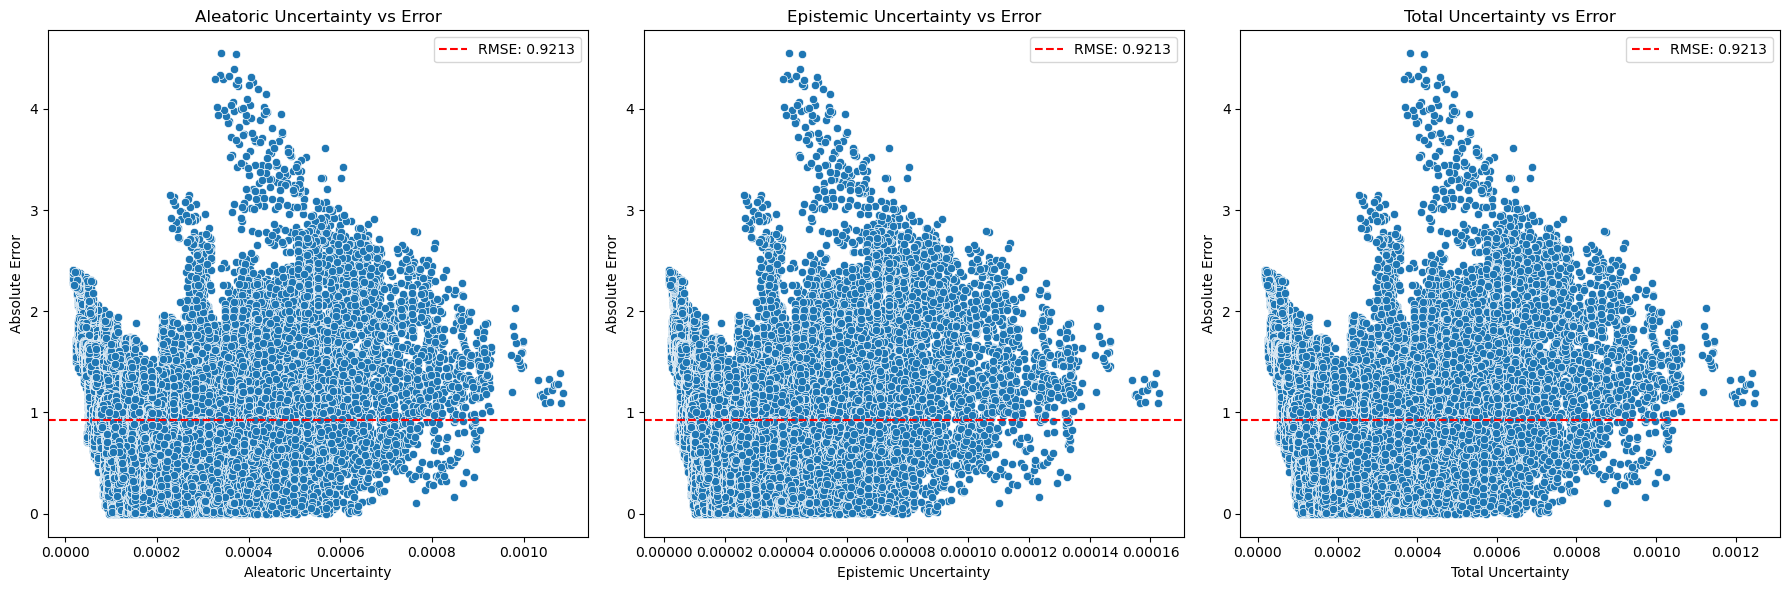

In [23]:
df = ppe_pred_[ppe_pred_['ppe_member'].isin(range(1, 500))]
# ---------- Calculate RMSE
rmse = np.sqrt(np.mean((df['ednn_pred'] - df['true_value']) ** 2))
# ---------- Calculate Absolute Error
df['absolute_error'] = np.abs(df['ednn_pred'] - df['true_value'])
# ---------- Calculate Total Uncertainty
df['total_uncertainty'] = df['ednn_alea'] + df['ednn_epis']

# =============================================================================
# Scatter Plots of Uncertainty vs. Absolute Error
# =============================================================================

# ---------- Create a figure with 1 row and 3 columns of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# ---------- Plot Aleatoric Uncertainty vs Absolute Error
sns.scatterplot(x=df['ednn_alea'], y=df['absolute_error'], ax=axes[0])
axes[0].axhline(rmse, color='r', linestyle='--', label=f'RMSE: {rmse:.4f}')
axes[0].set_xlabel('Aleatoric Uncertainty')
axes[0].set_ylabel('Absolute Error')
axes[0].set_title('Aleatoric Uncertainty vs Error')
axes[0].legend()

# ---------- Plot Epistemic Uncertainty vs Absolute Error
sns.scatterplot(x=df['ednn_epis'], y=df['absolute_error'], ax=axes[1])
axes[1].axhline(rmse, color='r', linestyle='--', label=f'RMSE: {rmse:.4f}')
axes[1].set_xlabel('Epistemic Uncertainty')
axes[1].set_ylabel('Absolute Error')
axes[1].set_title('Epistemic Uncertainty vs Error')
axes[1].legend()

# ---------- Plot Total Uncertainty vs Absolute Error
sns.scatterplot(x=df['total_uncertainty'], y=df['absolute_error'], ax=axes[2])
axes[2].axhline(rmse, color='r', linestyle='--', label=f'RMSE: {rmse:.4f}')
axes[2].set_xlabel('Total Uncertainty')
axes[2].set_ylabel('Absolute Error')
axes[2].set_title('Total Uncertainty vs Error')
axes[2].legend()

# ---------- Final layout adjustments and display the figure
plt.tight_layout()
plt.show()

Temporal Analysis

Analyze how predictions, errors, and uncertainties vary over time.

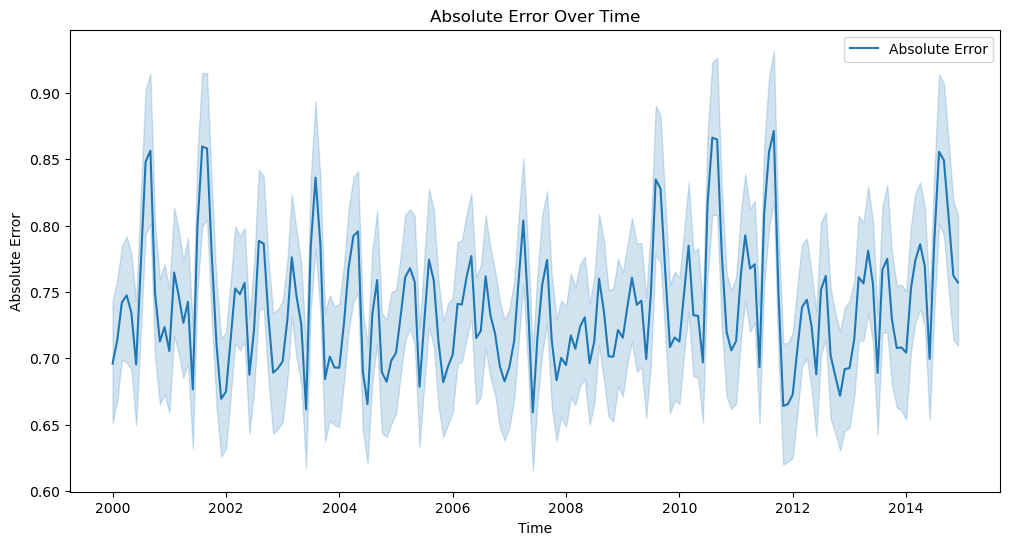

In [48]:
#-------------- Convert 'time' column to datetime
df['time'] = pd.to_datetime(df['time'])

#-------------- Plot absolute error over time
plt.figure(figsize=(12, 6))
sns.lineplot(x=df['time'], y=df['absolute_error'], label='Absolute Error')
plt.xlabel('Time')
plt.ylabel('Absolute Error')
plt.title('Absolute Error Over Time')
plt.legend()
plt.show()

Error Distribution

Analyze the distribution of prediction errors to identify patterns or outliers.



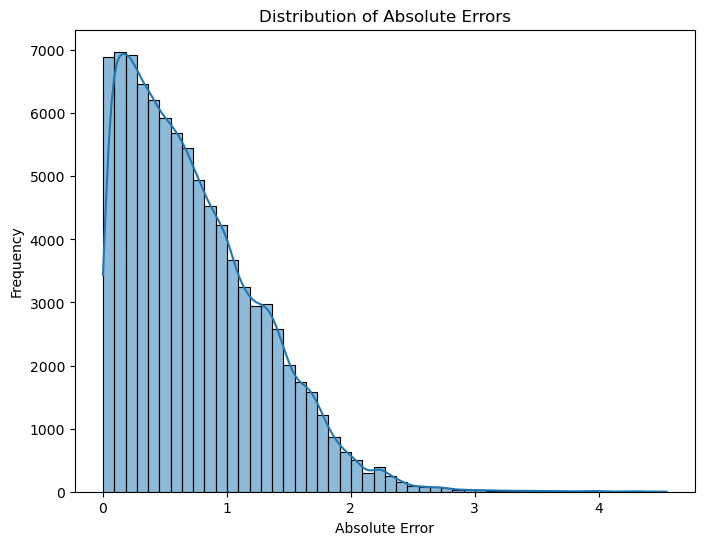

In [47]:
#-------------- Plot histogram of absolute errors
plt.figure(figsize=(8, 6))
sns.histplot(df['absolute_error'], bins=50, kde=True)
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.title('Distribution of Absolute Errors')
plt.show()

Uncertainty Distribution

Analyze the distribution of aleatoric and epistemic uncertainty.


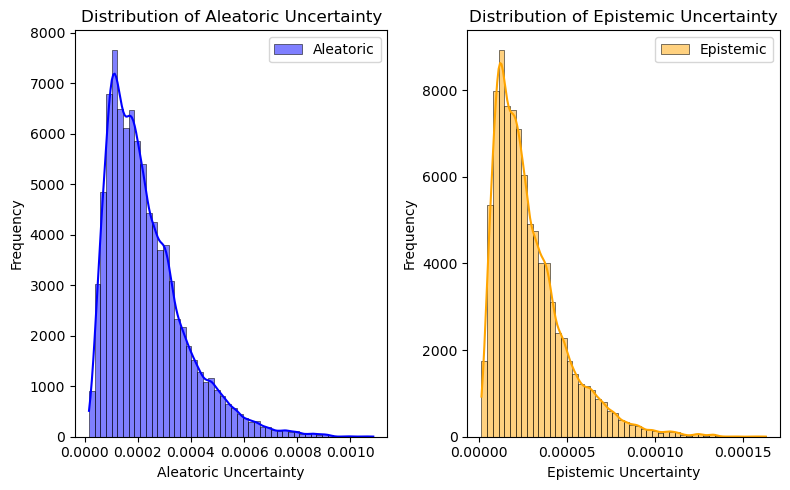

In [56]:
#-------------- Plot histogram of aleatoric uncertainty
plt.figure(figsize=(8, 5))
plt.subplot(1,2,1)
sns.histplot(df['ednn_alea'], bins=50, kde=True, color='blue', label='Aleatoric')
plt.xlabel('Aleatoric Uncertainty')
plt.ylabel('Frequency')
plt.title('Distribution of Aleatoric Uncertainty')
plt.legend()


#-------------- Plot histogram of epistemic uncertainty
plt.subplot(1,2,2)
sns.histplot(df['ednn_epis'], bins=50, kde=True, color='orange', label='Epistemic')
plt.xlabel('Epistemic Uncertainty')
plt.ylabel('Frequency')
plt.title('Distribution of Epistemic Uncertainty')
plt.legend()
plt.tight_layout()
plt.show()

Correlation Analysis

Analyze the correlation between predictions, errors, and uncertainties.



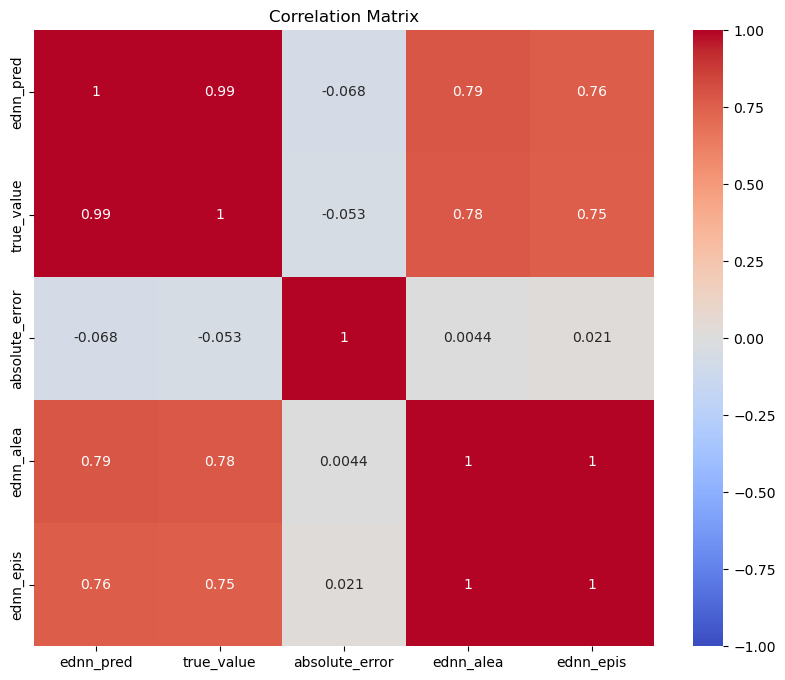

In [46]:
#-------------- Calculate correlation matrix
corr_matrix = df[['ednn_pred', 'true_value', 'absolute_error', 'ednn_alea', 'ednn_epis']].corr()

#-------------- Plot heatmap of correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

7. Error Decomposition

Decompose the error into bias and variance components.




In [29]:
# Calculate bias and variance
bias = np.mean(df['ednn_pred'] - df['true_value'])
variance = np.var(df['ednn_pred'] - df['true_value'])

print(f'Bias: {bias:.4f}')
print(f'Variance: {variance:.4f}')

Bias: 0.1413
Variance: 0.8287


Confidence Intervals

Calculate and visualize confidence intervals for predictions.

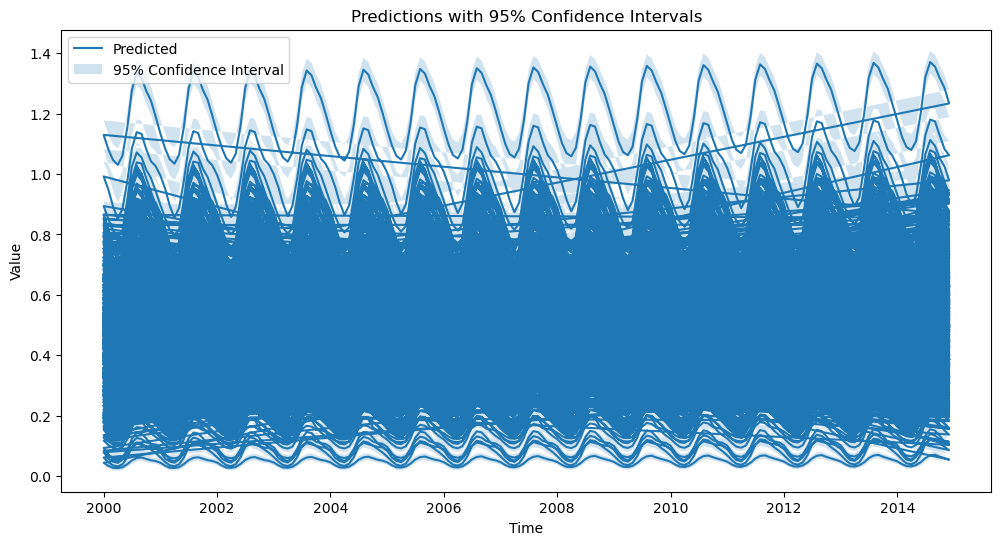

In [30]:
# Calculate 95% confidence intervals
confidence_interval = 1.96 * np.sqrt(df['total_uncertainty'])

# Plot predictions with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['ednn_pred'], label='Predicted')
plt.fill_between(df['time'], df['ednn_pred'] - confidence_interval, df['ednn_pred'] + confidence_interval, alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Predictions with 95% Confidence Intervals')
plt.legend()
plt.show()

Outlier Detection

Identify and analyze outliers in predictions and errors.

Number of outliers: 1056


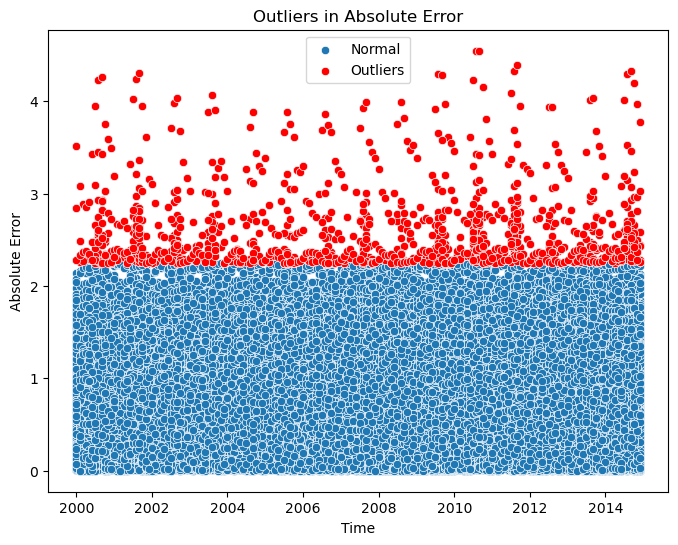

In [31]:
# Identify outliers using IQR
Q1 = df['absolute_error'].quantile(0.25)
Q3 = df['absolute_error'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['absolute_error'] < (Q1 - 1.5 * IQR)) | (df['absolute_error'] > (Q3 + 1.5 * IQR))]

print(f'Number of outliers: {len(outliers)}')

# Plot outliers
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['time'], y=df['absolute_error'], label='Normal')
sns.scatterplot(x=outliers['time'], y=outliers['absolute_error'], color='red', label='Outliers')
plt.xlabel('Time')
plt.ylabel('Absolute Error')
plt.title('Outliers in Absolute Error')
plt.legend()
plt.show()

Model Calibration

Assess the calibration of your model using reliability diagrams.

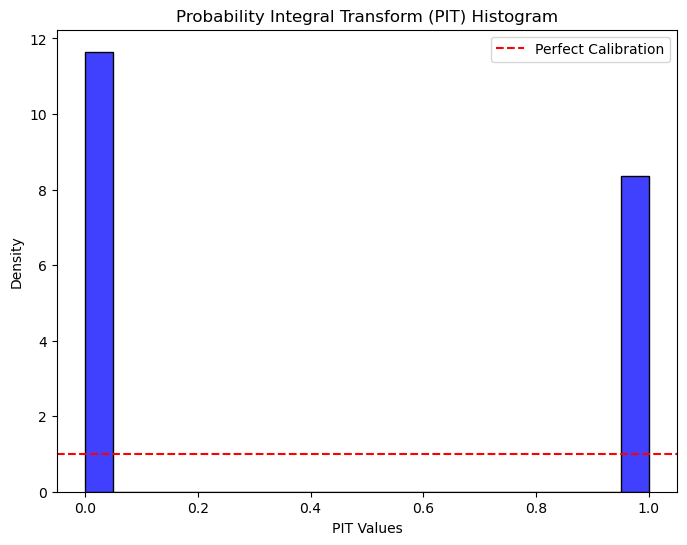

In [32]:
# Calculate PIT values
pit_values = np.zeros_like(df['true_value'])
for i in range(len(df)):
    pit_values[i] = np.mean(df['ednn_pred'][i] <= df['true_value'][i])

# Plot PIT histogram
plt.figure(figsize=(8, 6))
sns.histplot(pit_values, bins=20, kde=False, stat='density', color='blue')
plt.axhline(1, color='red', linestyle='--', label='Perfect Calibration')
plt.xlabel('PIT Values')
plt.ylabel('Density')
plt.title('Probability Integral Transform (PIT) Histogram')
plt.legend()
plt.show()

## Sensitivity Analysis 

In [33]:
def fast_model(x_data, model, pred, M=1, num_resamples=100, conf_level=0.95):
    """
    Fourier Amplitude Sensitivity Test (FAST) analysis on the given model output.

    Parameters:
    - Data: The model output.
    - params: DataFrame containing parameters.
    - num_params: The number of parameters.
    - N: The number of samples to generate for the FAST analysis.
    - M: The interference parameter, the number of harmonics to sum in the Fourier series decomposition (default 1).
    - num_resamples: The number of resamples for bootstrap (default 100).
    - conf_level: The confidence level for the bootstrap (default 0.95).

    This function first reshapes the model output and then performs the FAST analysis using the SALib library.
    """

    #--------------- Define the problem for FAST analysis
    problem = {
        'names': x_data.columns,
        'num_vars': len(x_data.columns),
        'bounds': [[-1.732, 1.73] for x in range(35)],
    }
    #---------------- Load model
    # loaded_emulator = tf.saved_model.load('/glade/work/ksilwimba/PPE-Optimization/NN_Emulator/Saved_Model/model_'+str(num))
    #---------------- Perform the FAST analysis
    sample = fast_sampler.sample(problem, 100000, M=2, seed=None)
    Y = model.predict(sample)#,return_uncertainties=True)
    # y_mean = Y.numpy().mean(axis=1).flatten()
    
    TWS_FAST = fast_analyze.analyze(problem, Y[:,pred].flatten(), M=2, num_resamples=1000,\
                            conf_level=0.95, print_to_console=True)
    #[mu, aleatoric, epistemic]
    return TWS_FAST 

In [34]:
#------------ Jan
tws_fast = fast_model(x_tr, model, pred=0, M=2, num_resamples=100000, conf_level=0.95)
Si_tws = pd.DataFrame.from_dict(tws_fast)
Si_tws.index = Si_tws.names
df_Si_tws = Si_tws.sort_values(by=['S1'],ascending=False)

3500/3500 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
                           S1        ST   S1_conf   ST_conf
FUN_fracfixers       0.013762  0.042660  0.000110  0.005507
KCN                  0.005725  0.030637  0.000110  0.005376
a_fix                0.009879  0.034998  0.000114  0.005261
crit_dayl            0.000222  0.025230  0.000109  0.005474
d_max                0.000748  0.025095  0.000113  0.005459
fff                  0.000324  0.023380  0.000111  0.005116
froot_leaf           0.032989  0.062288  0.000114  0.005381
fstor2tran           0.001168  0.027410  0.000109  0.005526
grperc               0.007512  0.038086  0.000105  0.005351
jmaxb0               0.137716  0.181274  0.000110  0.005221
jmaxb1               0.050954  0.077752  0.000113  0.005406
kcha                 0.000321  0.024339  0.000108  0.005416
kmax                 0.065521  0.096460  0.000110  0.005482
krmax                0.001231  0.027085  0.000106  0.005371
leaf_long            0.066615  0.096615  0.000113  0.0053

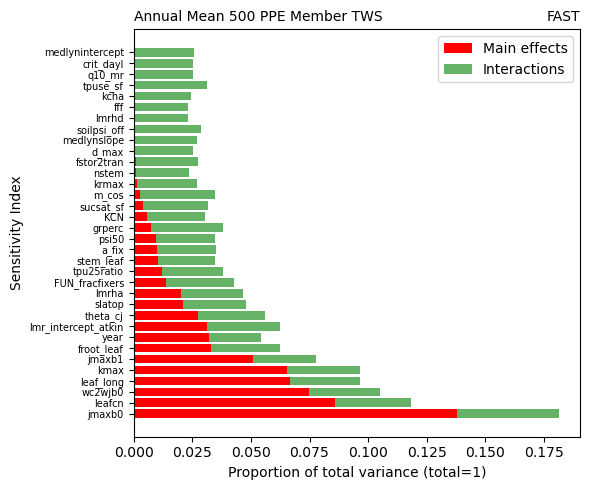

In [45]:
def plot_sensitivity(df, title, bar_color, ylabel=False, figsize=(9, 9)):
    fig, ax = plt.subplots(figsize=figsize) 
    ax.barh(df.names, df['S1'], color=bar_color, label='Main effects')  # Main effects
    ax.barh(df.names, df['ST'] - df['S1'], left=df['S1'], color='g', label='Interactions',alpha=0.6)  # Interaction effects stacked
    ax.set_yticklabels(df.names, rotation=0, fontsize=7)
    ax.legend(loc='upper right', frameon=True, shadow=True, fancybox=True)
    if ylabel:
        ax.set_xlabel('Proportion of total variance (total=1)')  # Use xlabel instead of ylabel for horizontal bars
    ax.set_title(title, loc='left', fontsize=10)
    ax.set_title('FAST', loc='right', fontsize=10)
    
    if ylabel:
        ax.set_ylabel('Sensitivity Index')
    ax.legend()
    
    plt.tight_layout()
    
plot_sensitivity(df_Si_tws.drop('m_sin', axis=0),'Annual Mean 500 PPE Member TWS', 'r', ylabel=True, figsize=(6, 5))
plt.savefig("./Figures/fast_season.pdf", format='pdf', bbox_inches='tight')

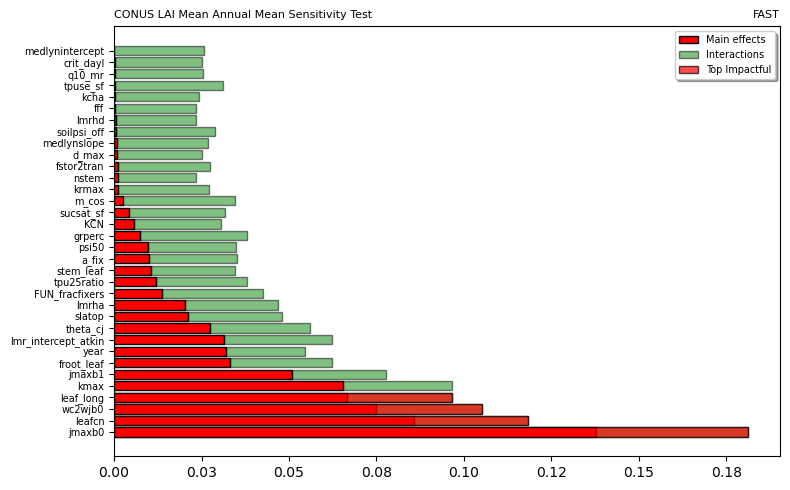

In [43]:
# =============================================================================
## FAST Sensitivity Analysis Plot with Highlighting
# =============================================================================

# ---------- Define the helper function for plotting FAST sensitivity analysis
def plot_sensitivity(ax, df, title, bar_color, xlabel=False):
    """
    Plot FAST sensitivity analysis results as horizontal bar charts, highlighting the top 4 impactful parameters.

    Parameters:
        ax (matplotlib.axes.Axes): Axis object to plot on.
        df (pd.DataFrame): DataFrame containing sensitivity data with columns 'names', 'S1', and 'ST'.
        title (str): Title for the subplot.
        bar_color (str): Color for the main effects bars.
        xlabel (bool, optional): If True, adds an x-axis label. Default is False.
    """
    # ---------- Identify the top 4 impactful parameters based on total sensitivity (ST)
    top_params = df.nlargest(4, 'ST')

    # ---------- Plot horizontal bars for main effects
    ax.barh(df.names, df['S1'], color=bar_color, label='Main effects', edgecolor='black')

    # ---------- Plot horizontal bars for interaction effects (stacked on main effects)
    ax.barh(df.names, df['ST'] - df['S1'], left=df['S1'], color='g', label='Interactions', alpha=0.5, edgecolor='black')

    # ---------- Highlight the top 4 parameters by re-plotting them in red
    for name in top_params.names:
        idx = df.names.tolist().index(name)
        ax.barh(df.names[idx], df['ST'][idx], color='r', alpha=0.7, edgecolor='black', label='Top Impactful' if idx == 0 else None)

    # ---------- Customize y-axis tick labels
    ax.set_yticklabels(df.names, rotation=0, fontsize=7)
    ax.legend(loc='upper right', frameon=True, shadow=True, fancybox=True, fontsize=7)

    # ---------- Add x-axis label if specified
    if xlabel:
        ax.set_xlabel('Proportion of total variance (total=1)')

    # ---------- Format x-axis ticks to 2 decimal places
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # ---------- Set subplot title (left-aligned) and add a "FAST" label on the right
    ax.set_title(title, loc='left', fontsize=8)
    ax.set_title('FAST', loc='right', fontsize=8)

# ---------- Create a single subplot for FAST sensitivity analysis
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=100)

# ---------- Plot sensitivity using the first dataset after dropping the 'm_sin' row
plot_sensitivity(ax, df_Si_tws.drop('m_sin', axis=0), 
                 'CONUS LAI Mean Annual Mean Sensitivity Test', 'r', xlabel=False)

# ---------- Adjust layout and save the figure as a PDF
plt.tight_layout()
plt.savefig("./Figures/fast_single_highlight.pdf", format='pdf', bbox_inches='tight')
plt.show()


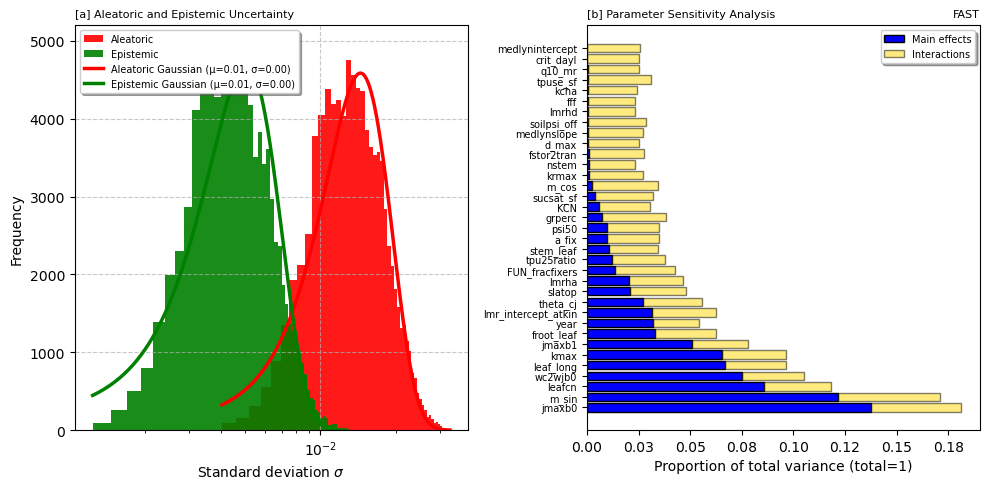

In [37]:
# =============================================================================
# Combined Plots: Histogram with Gaussian Fits and FAST Sensitivity Analysis
# =============================================================================

# ---------- Data for Aleatoric and Epistemic uncertainties: Compute square-root transforms
alea_data = np.sqrt(ppe_pred["ednn_alea"])
epis_data = np.sqrt(ppe_pred["ednn_epis"])

# ---------- Compute Gaussian fit for Aleatoric uncertainty
alea_mean = np.mean(alea_data)
alea_std = np.std(alea_data)
alea_x = np.linspace(alea_data.min(), alea_data.max(), 500)
# Scale the Gaussian to match histogram counts:
alea_gaussian = norm.pdf(alea_x, alea_mean, alea_std) * len(alea_data) * (alea_data.max() - alea_data.min()) / 50

# ---------- Compute Gaussian fit for Epistemic uncertainty
epis_mean = np.mean(epis_data)
epis_std = np.std(epis_data)
epis_x = np.linspace(epis_data.min(), epis_data.max(), 500)
epis_gaussian = norm.pdf(epis_x, epis_mean, epis_std) * len(epis_data) * (epis_data.max() - epis_data.min()) / 50

# ---------- Define the helper function for plotting FAST sensitivity analysis
def plot_sensitivity(ax, df, title, bar_color, xlabel=False):
    """
    Plots horizontal bar charts for FAST sensitivity analysis.
    
    Parameters:
        ax (matplotlib.axes.Axes): Axis on which to plot.
        df (pd.DataFrame): DataFrame containing sensitivity data with columns: 'names', 'S1', and 'ST'.
        title (str): Title for the subplot.
        bar_color (str): Color for the main effects bars.
        xlabel (bool, optional): If True, adds an x-axis label. Default is False.
    """
    # ---------- Plot horizontal bar for main effects
    ax.barh(df["names"], df['S1'], color=bar_color, label="Main effects", edgecolor="black")
    
    # ---------- Plot horizontal bar for interaction effects (stacked on main effects)
    ax.barh(df["names"], df["ST"] - df["S1"], left=df["S1"], color="gold", label="Interactions", alpha=0.5, edgecolor="black")
    
    # ---------- Customize y-axis tick labels
    ax.set_yticks(range(len(df)))
    ax.set_yticklabels(df["names"], rotation=0, fontsize=7)
    
    # ---------- Add legend to the plot
    ax.legend(loc="upper right", frameon=True, shadow=True, fancybox=True, fontsize=7)
    
    # ---------- Add x-axis label only if specified
    if xlabel:
        ax.set_xlabel("Proportion of total variance (total=1)")
    
    # ---------- Format x-axis ticks to 2 decimal places
    ax.xaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    
    # ---------- Set subplot title: left-aligned with title and right-aligned with "FAST"
    ax.set_title(title, loc="left", fontsize=8)
    ax.set_title("FAST", loc="right", fontsize=8)

# ---------- Create a figure with 1 row and 2 columns of subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=100)

# ---------- Left subplot: Plot histogram with Gaussian fits for Aleatoric and Epistemic uncertainties
axes[0].set_xscale("log")
axes[0].hist(alea_data, bins=50, alpha=0.9, color="r", label="Aleatoric", density=False)
axes[0].hist(epis_data, bins=50, alpha=0.9, color="g", label="Epistemic", density=False)
axes[0].plot(alea_x, alea_gaussian, "r", linewidth=2.5, label=f"Aleatoric Gaussian (µ={alea_mean:.2f}, σ={alea_std:.2f})")
axes[0].plot(epis_x, epis_gaussian, "g", linewidth=2.5, label=f"Epistemic Gaussian (µ={epis_mean:.2f}, σ={epis_std:.2f})")
axes[0].set_xlabel("Standard deviation $\sigma$")
axes[0].set_ylabel("Frequency")
axes[0].legend(loc="upper left", fontsize=7, frameon=True, shadow=True, fancybox=True)
axes[0].grid(True, linestyle="--", alpha=0.7)
axes[0].set_title("[a] Aleatoric and Epistemic Uncertainty", loc="left", fontsize=8)

# ---------- Right subplot: Plot FAST sensitivity analysis
plot_sensitivity(axes[1], df_Si_tws, "[b] Parameter Sensitivity Analysis", "blue", xlabel=True)

# ---------- Adjust layout and save the figure as a PDF
plt.tight_layout()
plt.savefig("./Figures/combined_plots.pdf", format="pdf", bbox_inches="tight")
plt.show()


## Cyclical Enconding Figure 

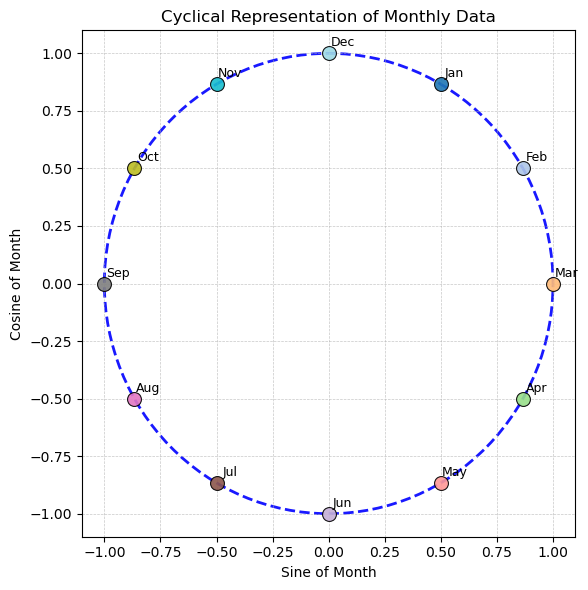

In [38]:
# =============================================================================
# Cyclical Representation of Monthly Data
# =============================================================================

# ---------- Define months and compute cyclical representations using sine and cosine
months = np.arange(1, 13)
period = 12
m_sin = np.sin(2 * np.pi * months / period)
m_cos = np.cos(2 * np.pi * months / period)

# ---------- Create a figure for the circular plot
plt.figure(figsize=(6, 6))

# ---------- Use a colormap to assign unique colors for each month
colors = plt.cm.tab20(np.linspace(0, 1, 12))

# ---------- Add a dashed circle (unit circle) for reference, with lower z-order
circle = plt.Circle((0, 0), 1, edgecolor='blue', facecolor='none', linestyle='--', linewidth=2, zorder=1, alpha=0.9)
plt.gca().add_artist(circle)

# ---------- Create scatter plot for each month with improved styling
for i, (x, y, color) in enumerate(zip(m_sin, m_cos, colors)):
    plt.scatter(x, y, alpha=0.9, edgecolors='black', color=color, linewidth=0.8, s=100, label=f"{i+1}", zorder=2)

# ---------- Annotate the months with their names for clarity
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for i, (x, y) in enumerate(zip(m_sin, m_cos)):
    plt.annotate(
        month_names[i],
        (x, y),
        textcoords="offset points",
        xytext=(10, 5),  # Offset text for better readability
        ha='center',
        fontsize=9,
        color='black',
        zorder=3
    )

# ---------- Set axis limits, labels, and title
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xlabel('Sine of Month')
plt.ylabel('Cosine of Month')
plt.title('Cyclical Representation of Monthly Data', fontsize=12)

# ---------- Adjust layout and save the figure as a PDF
plt.tight_layout()
plt.savefig("./Figures/circular_plot_month_improved.pdf", bbox_inches='tight')
plt.show()
